In [1]:
from stackrecommender import Recommender
from stacksite import StackSite
import numpy as np
import pandas as pd
from sklearn.cross_validation import KFold
import warnings
import pickle as pkl

warnings.filterwarnings("ignore")

In [3]:
x = 37

In [4]:
pkl.dump(x, open('test.pkl','wb'))

In [2]:
# start with a smaller site so things don't take fooooorever
site_name = 'datascience.stackexchange.com'

In [3]:
site = StackSite(site_name)

In [4]:
df_dict = site.generate_dfs()

# Generate K-Fold Test/Train Splits

I'll generate train/test splits for the questions and comments (the former is obvious, the latter is just to be fair about training the internal gensim dictionary on an appropriately smaller corpus). Then for each fold, I need to break `answers df` into two pieces according to whether the `parent_id` is in the train or test split. 

I'll treat `tags_df` as static (since according to StackExchange, it shouldn't change often), and I don't use `users_df` for anything (future features will allow `user_df` <-> `display_name` conversions).

In [5]:
df_names = ['questions', 'comments']
df_lengths = {name:len(site.df(name)) for name in df_names}

In [6]:
df_lengths

{'comments': 1045, 'questions': 325}

In [7]:
# generate the train/test split index arrays
n_folds = 5
folds = {name:KFold(df_lengths[name], n_folds=n_folds) for name in df_names}

In [8]:
# generate the train/test dataframes
train_dfs = {name:[] for name in df_names}
test_dfs = {name:[] for name in df_names}
for name in df_names:
    for test, train in folds[name]:
        train_dfs[name].append(site.df(name).ix[train])
        test_dfs[name].append(site.df(name).ix[test])

In [9]:
train_dfs['questions'][0].head()

user_id                                              title  \
post_id                                                              
5             5  How can I do simple machine learning without h...   
7            36  What open-source books (or other materials) pr...   
14           66           Is Data Science the Same as Data Mining?   
15           64  What are the advantages and disadvantages of S...   
16           63    Use liblinear on big data for semantic analysis   

                                                      tags  \
post_id                                                      
5                                       [machine-learning]   
7                                 [education, open-source]   
14                              [data-mining, definitions]   
15                                             [databases]   
16       [machine-learning, bigdata, liblinear, libsvm,...   

                                                  question  \
post_id                                                      
5        I've always been interested in machine learnin...   
7        As a researcher and instructor, I'm looking fo...   
14       I am sure data science as will be discussed in...   
15       In which situations would one system be prefer...   
16       I use Libsvm to train data and predict classif...   

                              date  
post_id                             
5       2014-05-13 23:58:30.457000  
7       2014-05-14 00:11:06.457000  
14      2014-05-14 01:25:59.677000  
15      2014-05-14 01:41:23.110000  
16      2014-05-14 01:57:56.880000

In [10]:
# split answers_df according to the train/test split of questions_d
train_dfs['answers'] = range(n_folds)
test_dfs['answers'] = range(n_folds)
answers_df = site.df('answers').copy()

for j in range(n_folds):
    train_qids = set(train_dfs['questions'][j].index.unique()) # indices are already unique
    test_qids = set(test_dfs['questions'][j].index.unique()) # but df.index is mutable and not hashable
    train_dfs['answers'][j] = answers_df[answers_df.parent_id.isin(train_qids)]
    test_dfs['answers'][j] = answers_df[answers_df.parent_id.isin(test_qids)]

In [11]:
# pack the training sets into dictionaries of dataframes for the recommender
df_names.append('answers')
train_df_dicts = range(n_folds)
for j in range(n_folds):
    train_df_dicts[j] = {name:train_dfs[name][j] for name in df_names}
    train_df_dicts[j]['tags'] = site.df('tags')
    train_df_dicts[j]['users'] = site.df('users')

In [12]:
# users and scores are lists of users/scores lists (one list for each fold)
# question_ids is a list of lists of the corresponding question_ids
# questions is a list of lists of questions (one list for each fold)

users = [answers_df.user_id for answers_df in test_dfs['answers']]
scores = [answers_df.score for answers_df in test_dfs['answers']]
question_ids = [answers_df.parent_id for answers_df in test_dfs['answers']]
questions = range(n_folds)
for j in range(n_folds):
    questions[j] = [test_dfs['questions'][j][['title','question','tags']].ix[qid] for qid in question_ids[j]]
    
# make a list of dataframes
validate_dfs = range(n_folds)
for j in range(n_folds):
    validate_dfs[j] = pd.DataFrame(data=questions[j], index=question_ids[j])
    validate_dfs[j]['user_id'] = pd.Series(data=users[j].values, index=question_ids[j])
    validate_dfs[j]['score'] = pd.Series(data=scores[j].values, index=question_ids[j])

In [13]:
for i in range(n_folds):
    validate_dfs[i]['predicted_score'] = 0.
    validate_dfs[i]['support'] = 0.

# Validate

In [17]:
recommender = Recommender(site_name,train_df_dicts[0])

In [18]:
%time recommender.train()

CPU times: user 18.9 s, sys: 42.1 ms, total: 18.9 s
Wall time: 18.9 s


In [19]:
validate_dfs[0].head()

title  \
parent_id                                                      
266        What are some easy to learn machine-learning a...   
265        Can machine learning algorithms predict sports...   
265        Can machine learning algorithms predict sports...   
265        Can machine learning algorithms predict sports...   
266        What are some easy to learn machine-learning a...   

                                                    question  \
parent_id                                                      
266        Being new to machine-learning in general, I'd ...   
265        I have a variety of NFL datasets that I think ...   
265        I have a variety of NFL datasets that I think ...   
265        I have a variety of NFL datasets that I think ...   
266        Being new to machine-learning in general, I'd ...   

                         tags user_id  score  predicted_score  support  
parent_id                                                               
266        [machine-learning]     418      3                0        0  
265        [machine-learning]      97      2                0        0  
265        [machine-learning]     478      1                0        0  
265        [machine-learning]     418      3                0        0  
266        [machine-learning]     478      9                0        0

In [20]:
recommender.predicted_score(validate_dfs[0].user_id.irow(1), validate_dfs[0][['title','question','tags']].irow(1))

(12.691794895035571, 2)

In [21]:
recommender.save('temp')

In [22]:
recommender.load('temp')

In [23]:
%%time
for i in range(n_folds): #should be n_folds
    recommender = Recommender(site_name,train_df_dicts[i])
    recommender.train(iterations = 100, passes = 3)
    for j in range(len(validate_dfs[i])):
        pred_score, supp = recommender.predicted_score(validate_dfs[i].user_id.irow(j), 
                                                 validate_dfs[i][['title','question','tags']].irow(j))
        validate_dfs[i]['predicted_score'][j] = pred_score
        validate_dfs[i]['support'][j] = supp

CPU times: user 2min 29s, sys: 831 ms, total: 2min 30s
Wall time: 2min 30s


Timing results.

Digital Ocean

    pre-optimization: Wall time: 2min 21s
    post-optimization: Wall time: 4min 4s
    
Haha. Excellent. I guess for validation purposes I shouldn't precompute gensim similarity matrices.

# Make Some Pictures!

In [14]:
def regrelerror(results, reg = 3.):
    """ 
    Regularized relative squared error (mean and std).
    a_df = answers_df (for the histogram of answer scores from multi-answerers.
    """
    scores_diff = (reg + results.predicted - results.actual)**2 / (results.actual + reg)**2
    
    return scores_diff.mean(), scores_diff.std()

def plot_results(results, title, a_df = None, hist_actual = True, supp_threshold = 3):
    
    color1 = dark2_colors[1]
    color2 = dark2_colors[2]
    color3 = dark2_colors[4]
    
    grouped_results = results.groupby('actual')
    
    plt.figure(figsize=(15,6))
    plt.suptitle(title)    
    
    plt.subplot(121)
    plt.plot(grouped_results.mean().index, grouped_results.mean(), label = "Mean Predicted Score")
    plt.scatter(results.actual, results.predicted,
                alpha = 0.1, s = 50, label = "Scores")
    plt.xlabel('Actual Answer Score')
    plt.ylabel('Predicted Score')
    plt.ylim(-1,results.predicted.max())
    plt.xlim(-1,results.actual.max())
    x = np.linspace(-1, 30)
    plt.plot(x,x,'r-', alpha = 0.3, label = r'$100\%$ Accuracy')
    plt.legend(loc='upper left')
    remove_border()

    plt.subplot(122)
    bins = np.linspace(-3,30,32)
    if hist_actual:
        results.actual.hist(bins = bins, alpha = 0.5, label="Actual", color = color1)
        
    if a_df is not None:
        results.actual.hist(bins = bins, alpha = 0.1, label="Actual", color = color1)
        #here's a historgram of the scores from users who answered more than one question (where I had a chance)
        min_questions_answered = 3
        user_answers = a_df.groupby('user_id')
        multi_answerers = user_answers.score.mean()[user_answers.score.count() >= min_questions_answered].index
        malist = set(multi_answerers.tolist())
        xh, yh, oh = plt.hist(a_df[a_df.user_id.isin(malist)].score, bins = bins, 
                                                   alpha = 0.5, color=color2,
                                                   label="Actual (#answers > %d)" % (supp_threshold - 1))

        plt.ylim(0, 1.1 * max(xh))

    results.predicted.hist(bins = bins, alpha = 0.5, label="Predicted", color=color3)
    plt.legend(loc='upper right')
    remove_border()
    
    plt.show()
    
    print "Regularized relative squared error (mean, std):", regrelerror(results)
    print "-"*20
    print
    
    return

LDA

    num_topics = 20
    iterations = 100
    passes = 3
    k = 7
    w = [1,1,1] (title, question, tags)

In [25]:
results1 = pd.DataFrame(columns=['actual','predicted'])
results1.actual = pd.concat([vdf.score for vdf in validate_dfs])
results1.predicted = pd.concat([vdf.predicted_score for vdf in validate_dfs])

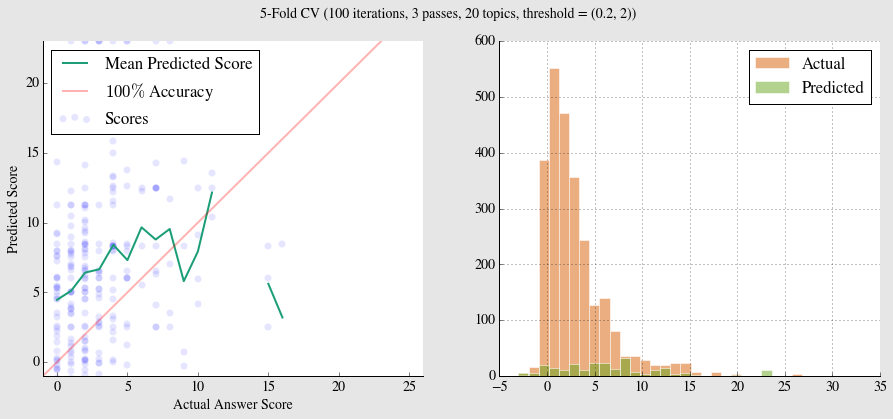

Regularized relative squared error (mean, std): (3.3350305655964387, 5.2622028515016028)
--------------------



In [26]:
plot_results(results1, '5-Fold CV (100 iterations, 3 passes, 20 topics, threshold = (0.2, 3))')

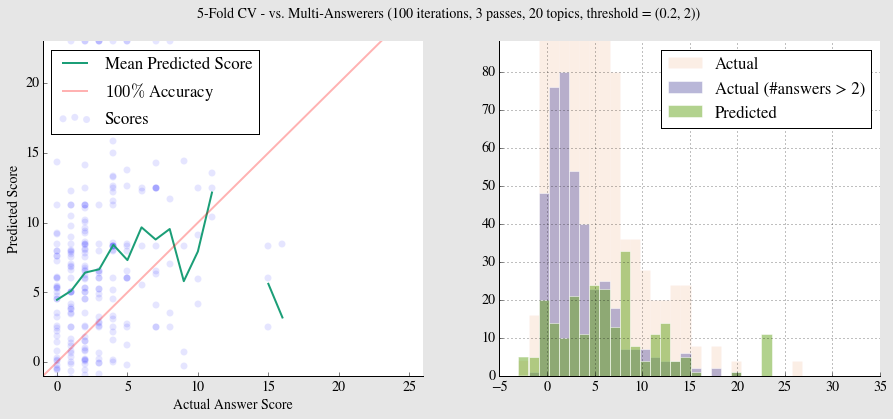

Regularized relative squared error (mean, std): (3.3350305655964387, 5.2622028515016028)
--------------------



In [27]:
plot_results(results1, '5-Fold CV - vs. Multi-Answerers (100 iterations, 3 passes, 20 topics, threshold = (0.2, 3))', a_df = answers_df, hist_actual=False)

# Cross-Validation (function w/ params)

In [15]:
def cv_recommender(k = 7, w = [1,1,1], num_topics = 20, iterations = 50, passes = 5, threshold = 0.2, supp_threshold = 3):
    """
    Uses the n_fold train/test splits to validate with the given parameters. Outputs 
    a dataframe with columns 'actual' and 'predicted'.
    
    WARNING: super hacky!
    """
    
    # make a list of dataframes
    validate_dfs = range(n_folds)
    for j in range(n_folds):
        validate_dfs[j] = pd.DataFrame(data=questions[j], index=question_ids[j])
        validate_dfs[j]['user_id'] = pd.Series(data=users[j].values, index=question_ids[j])
        validate_dfs[j]['score'] = pd.Series(data=scores[j].values, index=question_ids[j])
        
    for i in range(n_folds):
        validate_dfs[i]['predicted_score'] = 0.
        validate_dfs[i]['support'] = 0.

    for i in range(n_folds):
        recommender = Recommender(site_name, train_df_dicts[i], threshold = threshold, supp_threshold = supp_threshold)
        recommender.train(num_topics = num_topics, iterations = iterations, passes = passes)
        for j in range(len(validate_dfs[i])):
            pred_score, supp = recommender.predicted_score(validate_dfs[i].user_id.irow(j), 
                                                     validate_dfs[i][['title','question','tags']].irow(j),
                                                     k = k, w = w)
            validate_dfs[i]['predicted_score'][j] = pred_score
            validate_dfs[i]['support'][j] = supp
            
    results = pd.DataFrame(columns=['actual','predicted'])
    results.actual = pd.concat([vdf.score for vdf in validate_dfs])
    results.predicted = pd.concat([vdf.predicted_score for vdf in validate_dfs])
    
    return results

In [29]:
%%time
results2 = cv_recommender(num_topics=100, iterations=100, passes=3)

CPU times: user 9min 56s, sys: 24.9 s, total: 10min 21s
Wall time: 3min 14s


LDA

    num_topics = 100
    iterations = 100
    passes = 3
    k = 7
    w = [1,1,1] (title, question, tags)

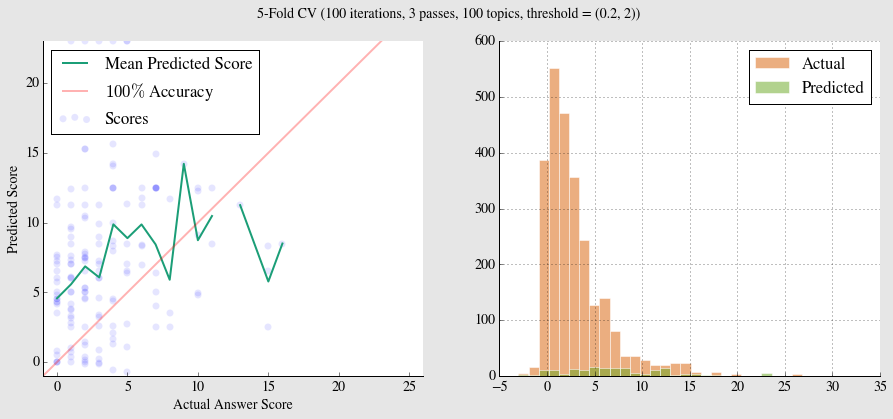

Regularized relative squared error (mean, std): (3.3175280050921399, 5.1820089920745493)
--------------------



In [30]:
plot_results(results2, '5-Fold CV (100 iterations, 3 passes, 100 topics, threshold = (0.2, 3))')

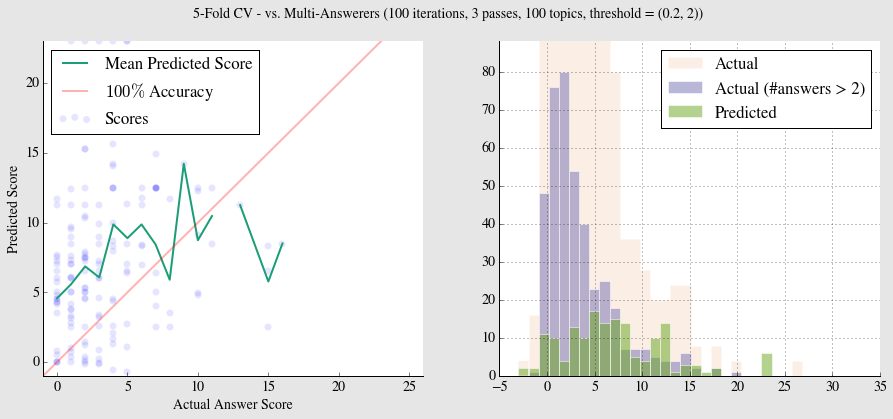

Regularized relative squared error (mean, std): (3.3175280050921399, 5.1820089920745493)
--------------------



In [31]:
plot_results(results2, '5-Fold CV - vs. Multi-Answerers (100 iterations, 3 passes, 100 topics, threshold = (0.2, 3))', a_df = answers_df, hist_actual=False)

In [16]:
%%time
results3 = cv_recommender(num_topics=100, iterations=100, passes=2, threshold = 0.1, supp_threshold = 2)

CPU times: user 10min 18s, sys: 24.5 s, total: 10min 43s
Wall time: 3min 25s


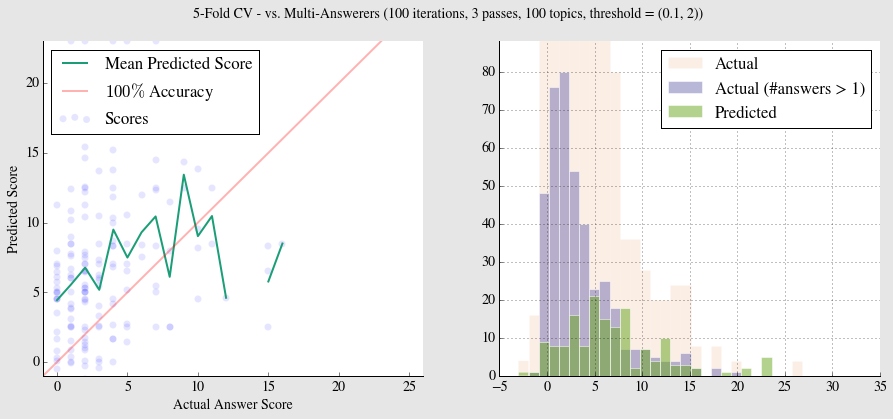

Regularized relative squared error (mean, std): (3.1980372556816477, 5.0318485111226563)
--------------------



In [19]:
plot_results(results3, '5-Fold CV - vs. Multi-Answerers (100 iterations, 3 passes, 100 topics, threshold = (0.1, 2))', a_df = answers_df, hist_actual=False, supp_threshold = 2)

In [20]:
%%time
results4 = cv_recommender(num_topics=100, iterations=100, passes=2, threshold = 0.05, supp_threshold = 1)

CPU times: user 9min 49s, sys: 24.4 s, total: 10min 13s
Wall time: 3min 3s


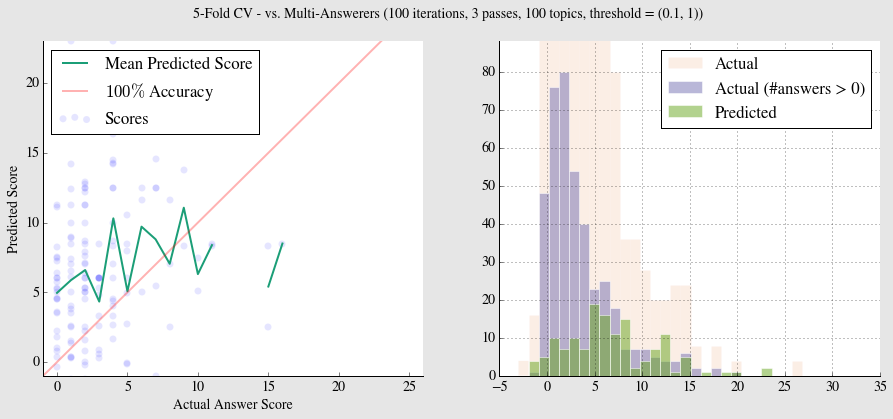

Regularized relative squared error (mean, std): (3.5436045644627248, 5.2163178606093208)
--------------------



In [21]:
plot_results(results4, '5-Fold CV - vs. Multi-Answerers (100 iterations, 3 passes, 100 topics, threshold = (0.1, 1))', a_df = answers_df, hist_actual=False, supp_threshold = 1)

I'm seriously underestimating the number of scores!

Things to check:

1. throwing out too many scores with `total_sim` = 0?

My thresholds might be throwing out lots of scores, but they would be zeros. That wouldn't have the right effect on the distribution anyway. I just hope things get better when I work on a bigger site!